## Initializations

In [4]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

grain = 100
p=1
t_1 = 1

#Note we take a=1

## Band Structure

In [5]:
def H(q, kx, ky): #Find the 2d-Hamiltonian matrix for some q-value at (k_x, k_y) in momentum space
    n_phi = p/q
    def A(m, ky):
        return -2*(t_1*np.cos(2*np.pi*n_phi*m + ky)+t_3*np.cos(4*np.pi*n_phi*m+2*ky))
    def B(m, kx, ky):
        return -t_1*np.exp(1j*kx)
        #return t_1*np.exp(1j*k_x)+t_3*np.exp(1j*2*np.pi*n_phi*(m+1/2))*np.exp(1j*k_x)*np.exp(1j*k_y)
    def C(kx):
        return -t_3 * np.exp(1j*2*kx)
    
    B_arr_temp = np.diag(np.array([B(i,kx,ky) for i in range(q)]))
    C_arr_temp = np.diag(np.array([C(kx) for i in range(q)]))
    
    A_arr = np.diag(np.array([A(i,ky) for i in range(q)]))
    B_arr = np.roll(B_arr_temp, 1, axis = 1)
    Bc_arr = np.conjugate(np.roll(B_arr_temp, 1, axis = 0))
    C_arr = np.roll(C_arr_temp, 2, axis = 1)
    Cc_arr = np.conjugate(np.roll(C_arr_temp, 2, axis = 0))
    
    return A_arr+B_arr+Bc_arr+C_arr+Cc_arr


def H_eigenvectors(q):
    #k_x, k_y = np.linspace(-np.pi/q, np.pi/q, grain), np.linspace(-np.pi, np.pi, grain)
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    eigenvectors_arr = np.empty((q, len(k_x), len(k_y), q),dtype = "complex_")
    for i, kx in enumerate(k_x):
        for j, ky in enumerate(k_y):
            matrix = H(q, kx, ky)
            assert(np.all(0 == (matrix - np.conj(matrix.T))))
            eigenvalues, eigenvectors = np.linalg.eigh(matrix)
            for a in range(q):
                eigenvectors_arr[a, i, j, :] = eigenvectors[:, a]
    return eigenvectors_arr

def H_eigenvalues(q):
    #k_x, k_y = np.linspace(-np.pi/q, np.pi/q, grain), np.linspace(-np.pi, np.pi, grain)
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    eigenvalues_arr = np.empty((q, len(k_x), len(k_y)))
    for i, kx in enumerate(k_x):
        for j, ky in enumerate(k_y):
            matrix = H(q, kx, ky)
            assert(np.all(0 == (matrix - np.conj(matrix.T))))
            eigenvalues, eigenvectors = np.linalg.eigh(matrix)
            for a in range(q):
                eigenvalues_arr[a, i, j] = eigenvalues[a]
    return eigenvalues_arr

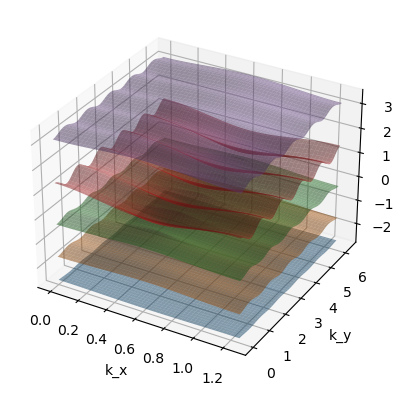

In [6]:
q=5
t_3 = -0.25
eigenvalues_arr = H_eigenvalues(q)
eigenvectors_arr = H_eigenvectors(q)

#k_x, k_y = np.linspace(-np.pi/q, np.pi/q, grain), np.linspace(-np.pi, np.pi, grain)
k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
K_x, K_y = np.meshgrid(k_x, k_y, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for a in range(q):
    ax.plot_surface(K_x, K_y, eigenvalues_arr[a], alpha=0.5)

ax.set_xlabel('k_x')
ax.set_ylabel('k_y')
ax.set_zlabel('Energy (t)')
plt.savefig('band_structure_t3=-025_q=5')
plt.show()
#print([eigenvalues_arr[i][0][0] for i in range(q)])

## Chern number

In [7]:
def chern_number(i, km_x, km_y):
    dx = (km_x[1] - km_x[0])
    dy = (km_y[1] - km_y[0])
    chern_sum = 0
    for xi in range(len(km_x) - 1):
        for yi in range(len(km_y) - 1):
            chern_sum += chern_number_helper(i,xi,yi)
    return (1/ (2 * np.pi)) * chern_sum


def chern_number_helper(i, x, y):
    psi_1 = eigenvectors_arr[i, x % len(k_x), y % len(k_y), :]
    psi_2 = eigenvectors_arr[i, (x + 1) % len(k_x), y % len(k_y), :]
    psi_3 = eigenvectors_arr[i, (x+1) % len(k_x), (y + 1) % len(k_y), :]
    psi_4 = eigenvectors_arr[i, x % len(k_x), (y + 1) % len(k_y), :]

    U12 = np.vdot(psi_1, psi_2)/np.abs(np.vdot(psi_1, psi_2))
    U23 = np.vdot(psi_2, psi_3)/np.abs(np.vdot(psi_2, psi_3))
    U34 = np.vdot(psi_3, psi_4)/np.abs(np.vdot(psi_3, psi_4))
    U41 = np.vdot(psi_4, psi_1)/np.abs(np.vdot(psi_4, psi_1))

    return -1*np.imag(np.log(U12*U23*U34*U41))

print([chern_number(i, k_x, k_y) for i in range(5)])

[1.0000000000000007, 1.000000000000004, 1.000000000000004, -3.9999999999999796, 1.0000000000000018]


## Wilson Loop

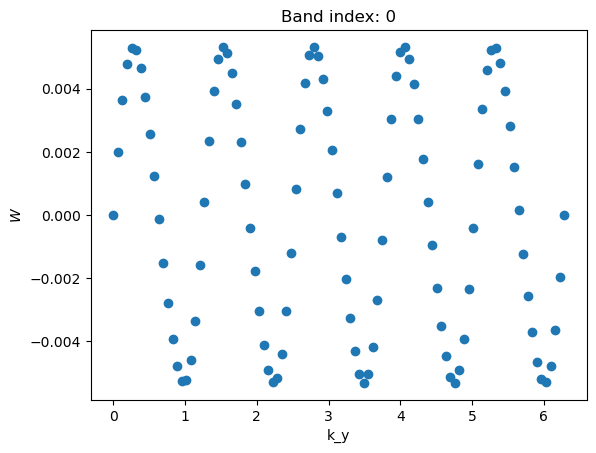

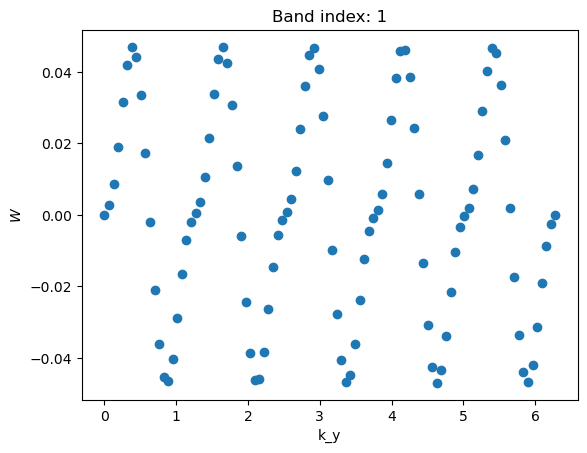

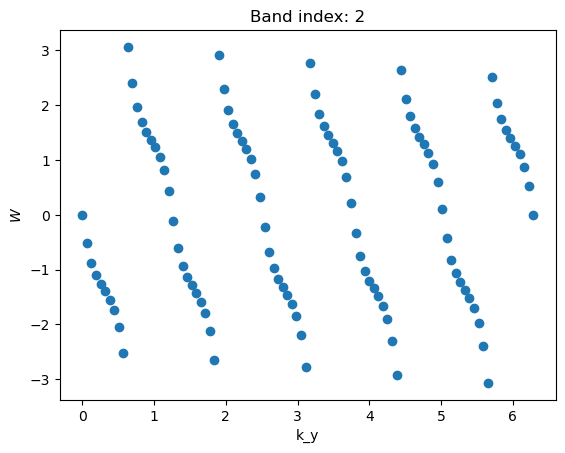

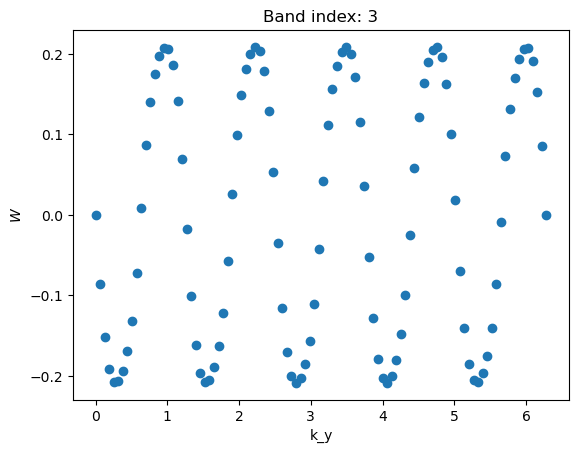

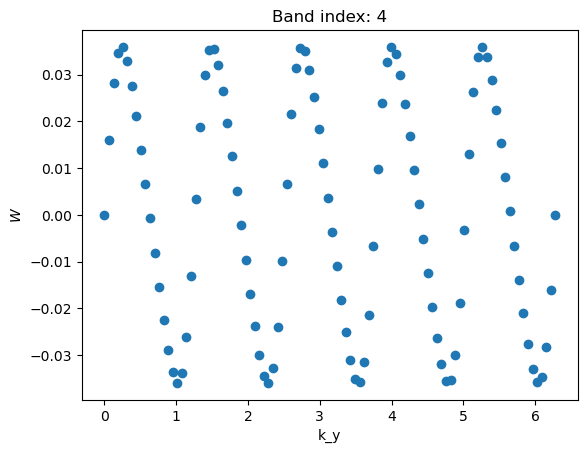

In [8]:
#Wilson loop in the x direction
def berry_phase(a, x, y):
    psi_0 = eigenvectors_arr[a, (x) % len(k_x), y % len(k_y), :]
    psi_1 = eigenvectors_arr[a, (x+1) % len(k_x), (y) % len(k_y), :]

    theta_01 = np.vdot(psi_0, psi_1)

    return theta_01
    
def wilson_loop_one(a, yi):
    product = 1
    for xi in range(len(k_x)):
        product *= berry_phase(a, xi, yi)
    wilson_output = -1*np.imag(np.log((product)))
    return wilson_output

for a in range(q):
    arr = np.empty(len(k_y))
    for i in range(len(k_y)):
        arr[i] = wilson_loop_one(a, i)
    plt.figure()
    plt.xlabel('k_y')
    plt.title('Band index: {}'.format(a))
    plt.ylabel(r'$W$')
    plt.scatter(k_y, arr)

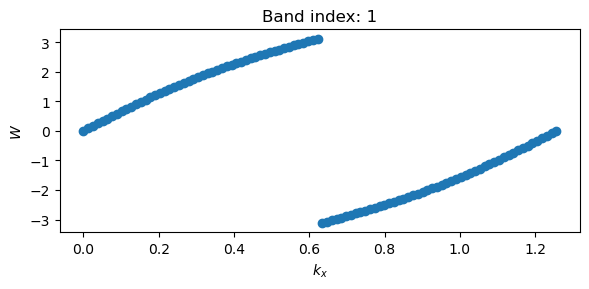

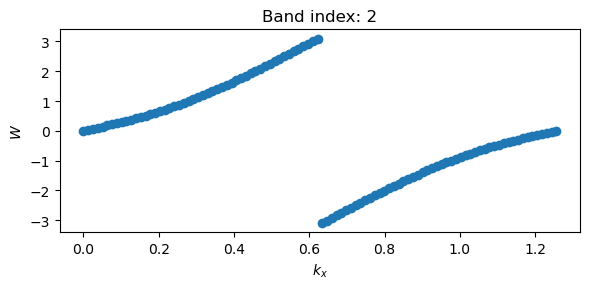

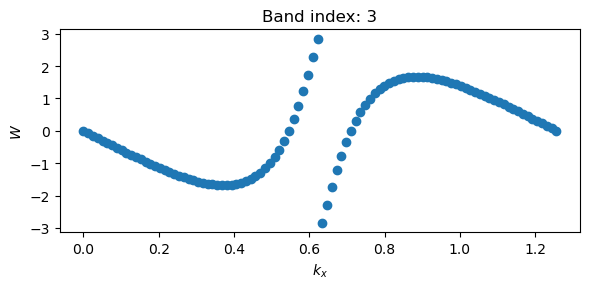

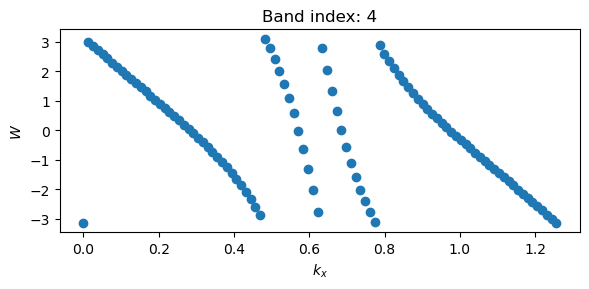

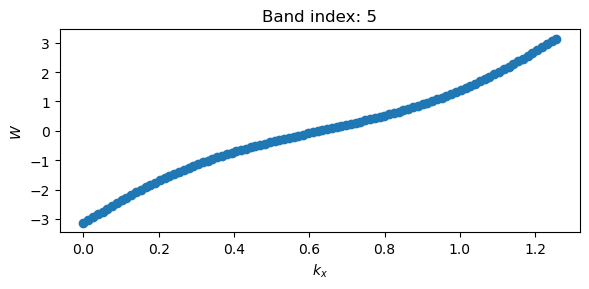

In [9]:
#Wilson loop in the y direction
k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
#k_x, k_y = np.linspace(-np.pi/q, np.pi/q, grain), np.linspace(-np.pi, np.pi, grain)
def berry_phase(a, x, y):
    psi_0 = eigenvectors_arr[a, (x) % len(k_x), y % len(k_y), :]
    psi_1 = eigenvectors_arr[a, (x) % len(k_x), (y+1) % len(k_y), :]

    theta_01 = np.vdot(psi_0, psi_1)

    return theta_01
    
def wilson_loop_one(a, xi):
    product = 1
    for yi in range(len(k_y)):
        product *= berry_phase(a, xi, yi)
    wilson_output = -1*np.imag(np.log((product)))
    return wilson_output

for a in range(q):
    arr = np.empty(len(k_x))
    for i in range(len(k_x)):
        arr[i] = wilson_loop_one(a, i)
    plt.figure(figsize=(6, 3))
    plt.xlabel(r'$k_x$')
    plt.ylabel(r'$W$')
    plt.title('Band index: {}'.format(a+1))
    plt.scatter(k_x, arr)
    plt.tight_layout()
    plt.savefig('wilson_loop_{}.png'.format(a+1), dpi = 1000)